In [3]:
!pip install ../input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install ../input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install ../input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install ../input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install ../input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


Processing /Users/christang/Desktop/kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
autograd is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /Users/christang/Desktop/kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4032 sha256=38c2e83e002a14acb05c4578f1ebf9ae7d05d3480b8aebbef1f46711f4a6bf2e
  Stored in directory: /Users/christang/Library/Caches/pip/wheels/15/fd/62/3f665ecd486ff3099f0072ebd10f6f1555611fde01228f8703
Successfully built autograd-gamma
  Attempting uninstall: autograd-gamma
    Found existing installation: autograd-gamma 0.5.0
    Uninstalling autograd-gamma-0.5.0:
      Successfully uninstalled autograd-gamma-0.5.0
Processing /Users/christang/Desktop/kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
int

In [2]:
pip install git+https://github.com/ResidentMario/missingno.git

  Cloning https://github.com/ResidentMario/missingno.git to /private/var/folders/88/lhd3dzzd50l3lv7f_687j5jc0000gn/T/pip-req-build-iy0i8bk6
  Running command git clone --filter=blob:none --quiet https://github.com/ResidentMario/missingno.git /private/var/folders/88/lhd3dzzd50l3lv7f_687j5jc0000gn/T/pip-req-build-iy0i8bk6
  Resolved https://github.com/ResidentMario/missingno.git to commit 570fa089ba6338e02342ed990bbc1b0bedc54314
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
import os

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [11]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer 
from sklearn.model_selection import train_test_split

In [12]:
import myutils.preprocessing as pp 
import myutils.visualization as vz
from metric import score as sc
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from lifelines import KaplanMeierFitter

In [4]:
def read_data(data_dir,fileNames):
    path = os.path.join(data_dir,fileNames)
    df = pd.read_csv(path)
    return df

In [5]:
data_dir = '../input'
fName1 = 'train.csv'
fName2 = 'test.csv'
fName3 = 'data_dictionary.csv'

trainData = read_data(data_dir,fName1)
testData = read_data(data_dir,fName2)
dataDict = read_data(data_dir,fName3)

random_seed = 20030309

# Data Understanding and Inspection

In [8]:
print(trainData.head(5))

   ID                       dri_score psych_disturb    cyto_score diabetes  \
0   0  N/A - non-malignant indication            No           NaN       No   
1   1                    Intermediate            No  Intermediate       No   
2   2  N/A - non-malignant indication            No           NaN       No   
3   3                            High            No  Intermediate       No   
4   4                            High            No           NaN       No   

   hla_match_c_high  hla_high_res_8          tbi_status arrhythmia  \
0               NaN             NaN              No TBI         No   
1               2.0             8.0  TBI +- Other, >cGy         No   
2               2.0             8.0              No TBI         No   
3               2.0             8.0              No TBI         No   
4               2.0             8.0              No TBI         No   

   hla_low_res_6  ...          tce_div_match donor_related  \
0            6.0  ...                    NaN    

In [9]:
print(trainData.shape)

(28800, 60)


In [10]:
print(trainData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [7]:
print(trainData.columns)

Index(['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_hi

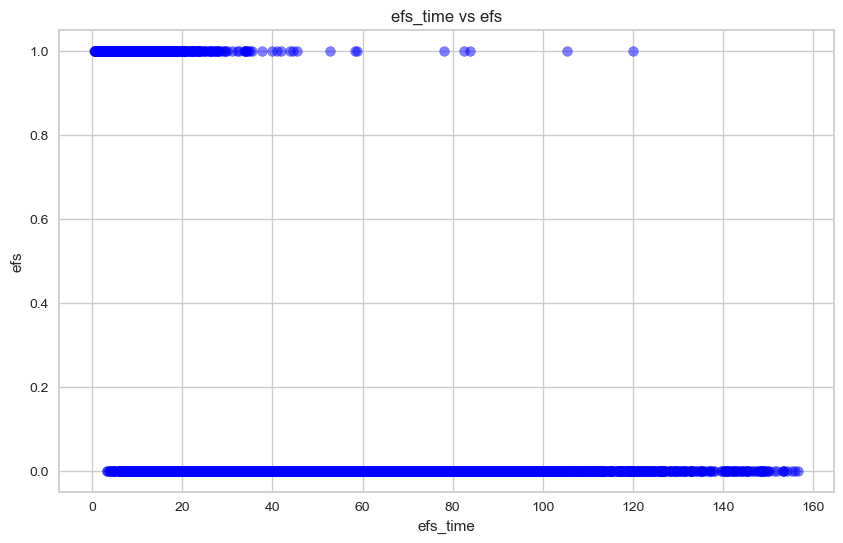

In [9]:
vz.scatter_plot(trainData,'efs_time','efs')

In [11]:
#inspecting missing values
missing_values = trainData.isnull().sum()
missing_values = missing_values.sort_values(ascending=False)
print(missing_values)

tce_match                 18996
mrd_hct                   16597
cyto_score_detail         11923
tce_div_match             11396
tce_imm_match             11133
cyto_score                 8068
hla_high_res_10            7163
hla_high_res_8             5829
hla_high_res_6             5284
hla_match_dqb1_high        5199
hla_low_res_10             5064
conditioning_intensity     4789
hla_match_c_high           4620
hla_match_a_high           4301
hla_nmdp_6                 4197
hla_match_dqb1_low         4194
hla_match_b_high           4088
hla_low_res_8              3653
hla_match_drb1_high        3352
hla_low_res_6              3270
hla_match_c_low            2800
hla_match_drb1_low         2643
hla_match_b_low            2565
cardiac                    2542
peptic_ulcer               2419
hla_match_a_low            2390
arrhythmia                 2202
rheum_issue                2183
rituximab                  2148
pulm_severe                2135
diabetes                   2119
psych_di

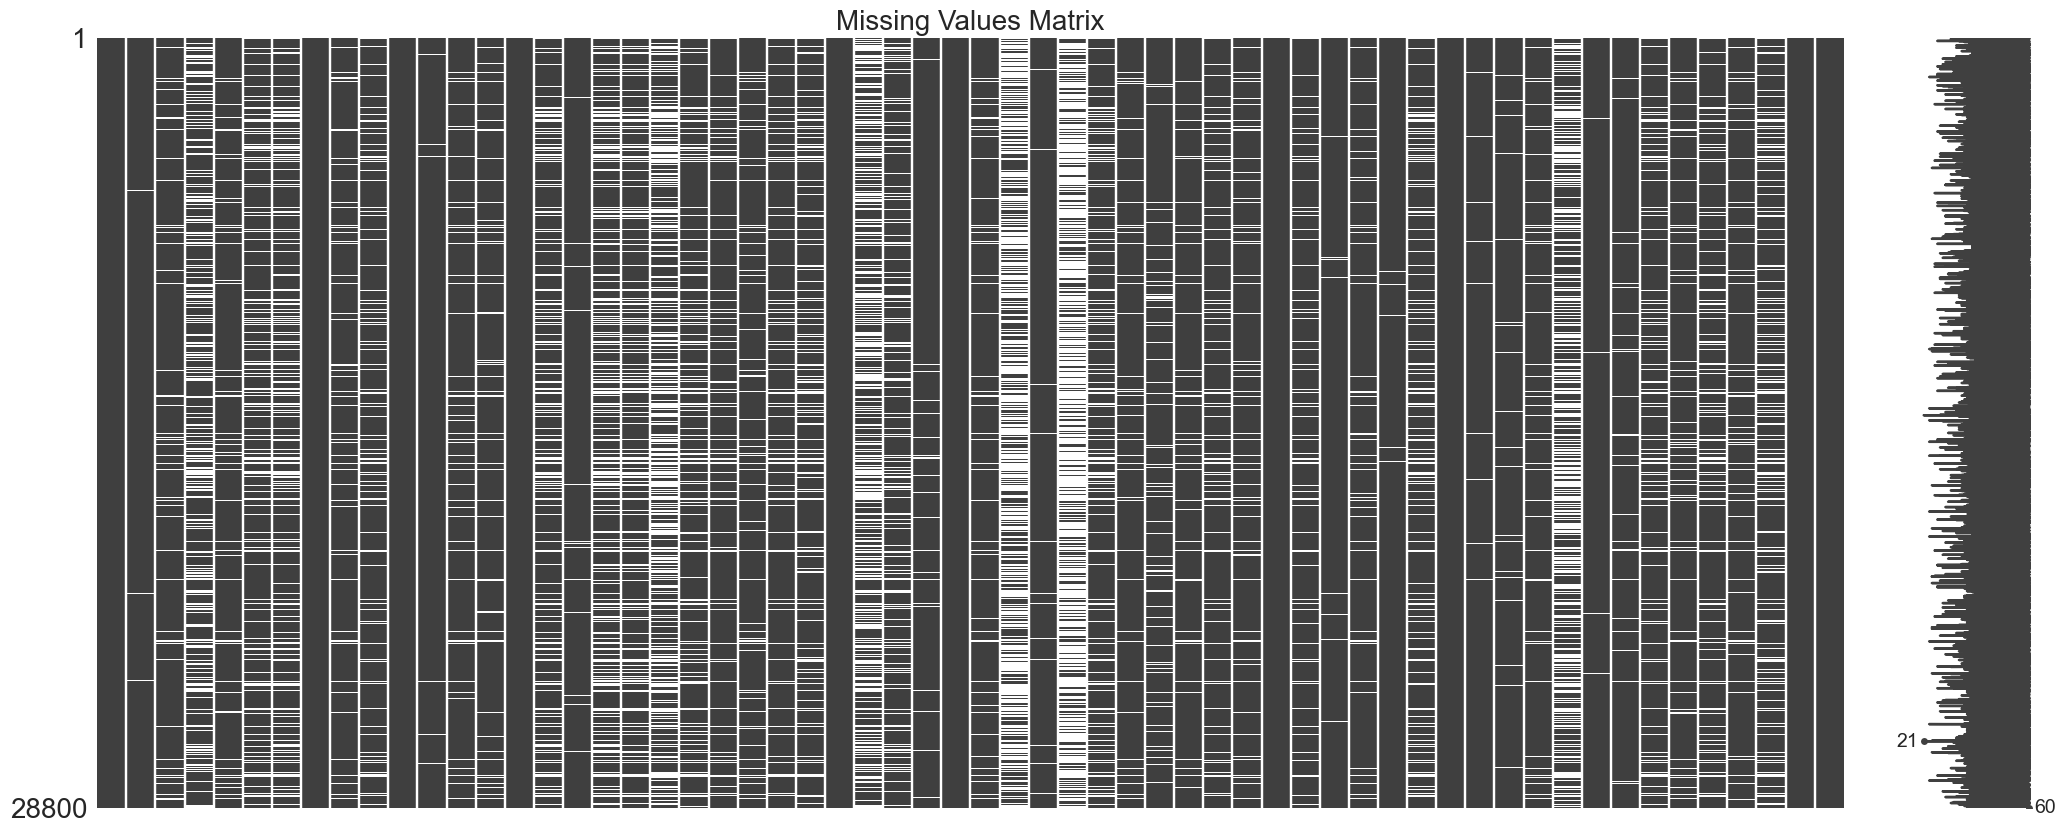

In [12]:
#plot the missing values heatmap
vz.plot_missing_values(trainData)

Due to the large number of missing values and unclearness of the patterns in the values that are missing, regular imputation methods will not be considered to use as the training accuracy could be severly impaired.

In [13]:
#Understanding the missing values
missing_values = pp.missing_val_df(trainData)
missing_values = missing_values.merge(dataDict[['variable', 'description']], left_on='variables', right_on='variable', how='left')
missing_values.drop(columns=['variable'], inplace=True)
missing_values.rename(columns={'description': 'Variable Description'}, inplace=True)

missing_values

,variables,Missing Values,Missing Percent,Data Type,Variable Description
0,tce_match,18996,65.96,object,T-cell epitope matching
1,mrd_hct,16597,57.63,object,MRD at time of HCT (AML/ALL)
2,cyto_score_detail,11923,41.40,object,Cytogenetics for DRI (AML/MDS)
3,tce_div_match,11396,39.57,object,T-cell epitope matching
4,tce_imm_match,11133,38.66,object,T-cell epitope immunogenicity/diversity match
5,cyto_score,8068,28.01,object,Cytogenetic score
6,hla_high_res_10,7163,24.87,float64,Recipient / 1st donor allele-level (high resol...
7,hla_high_res_8,5829,20.24,float64,Recipient / 1st donor allele-level (high resol...
8,hla_high_res_6,5284,18.35,float64,Recipient / 1st donor allele-level (high resol...
9,hla_match_dqb1_high,5199,18.05,float64,Recipient / 1st donor allele level (high resol...


In [14]:
# Detect duplicate rows
duplicate_rows = trainData[trainData.duplicated()]

# Show duplicate rows
print(duplicate_rows)

Empty DataFrame
Columns: [ID, dri_score, psych_disturb, cyto_score, diabetes, hla_match_c_high, hla_high_res_8, tbi_status, arrhythmia, hla_low_res_6, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, hla_high_res_6, cmv_status, hla_high_res_10, hla_match_dqb1_high, tce_imm_match, hla_nmdp_6, hla_match_c_low, rituximab, hla_match_drb1_low, hla_match_dqb1_low, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, year_hct, obesity, mrd_hct, in_vivo_tcd, tce_match, hla_match_a_high, hepatic_severe, donor_age, prior_tumor, hla_match_b_low, peptic_ulcer, age_at_hct, hla_match_a_low, gvhd_proph, rheum_issue, sex_match, hla_match_b_high, race_group, comorbidity_score, karnofsky_score, hepatic_mild, tce_div_match, donor_related, melphalan_dose, hla_low_res_8, cardiac, hla_match_drb1_high, pulm_moderate, hla_low_res_10, efs, efs_time]
Index: []

[0 rows x 60 columns]


# Data Preprocessing

In [39]:
#We will perform data preprocessing on the numerical variables and categorical variables separately.
trainData_num = pp.numeric_df(trainData)
trainData_num
missing_values_num = pp.missing_val_df(trainData_num)

testData_num = pp.numeric_df(testData)

In [40]:
missing_values_num

,variables,Missing Values,Missing Percent,Data Type
0,hla_high_res_10,7163,24.87,float64
1,hla_high_res_8,5829,20.24,float64
2,hla_high_res_6,5284,18.35,float64
3,hla_match_dqb1_high,5199,18.05,float64
4,hla_low_res_10,5064,17.58,float64
5,hla_match_c_high,4620,16.04,float64
6,hla_match_a_high,4301,14.93,float64
7,hla_nmdp_6,4197,14.57,float64
8,hla_match_dqb1_low,4194,14.56,float64
9,hla_match_b_high,4088,14.19,float64


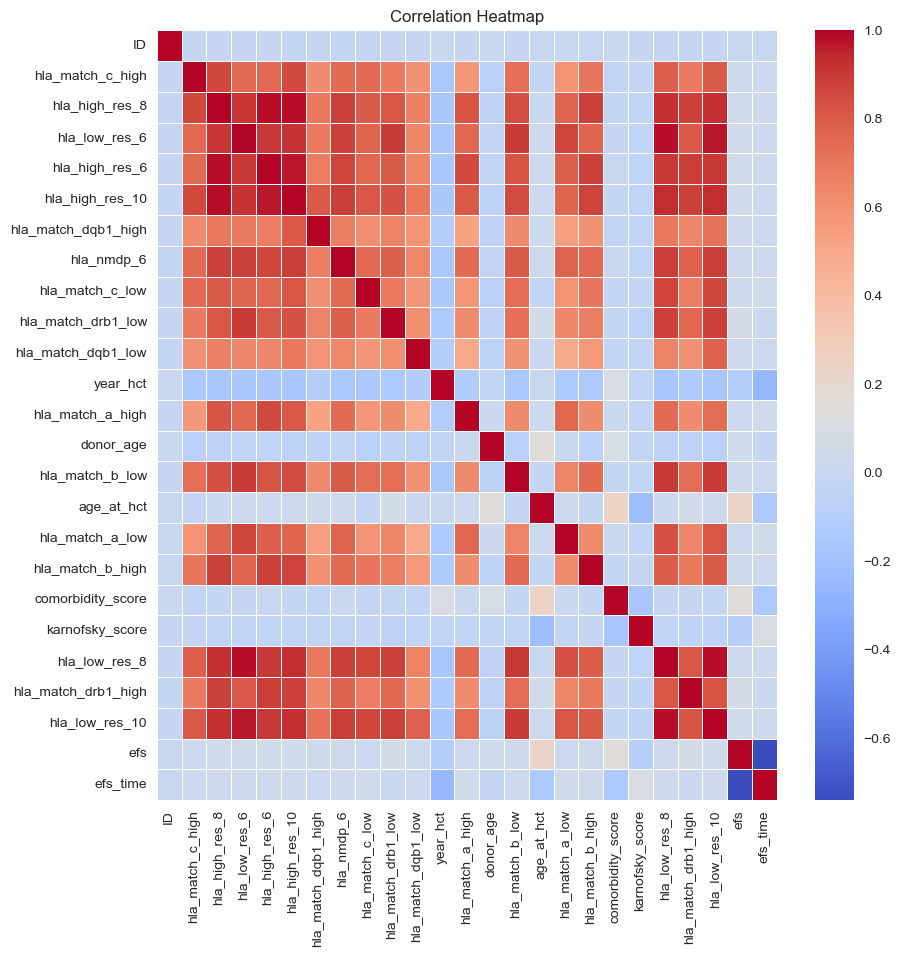

In [41]:
#Plot the correlation heatmap between numerical variables to check for multicollinearity, 
#before we decide on which imputation method to use.
vz.cor_heatmap(trainData_num)

As we can see, the variables that starts with "hla" seems to be highly correlated with on another, while the other variables do not exhibited clear correlation.
Therefore, we decided to employ KNN (similarity based) imputer on all the variables that start with "hla" and Iterative imputer for the rest of the variables.

In [18]:
hla_columns = [col for col in trainData_num.columns if col.startswith('hla_')]
hla_data = trainData_num[hla_columns]

hla_columns_test = [col for col in testData.columns if col.startswith('hla_')]

# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=3, weights="distance")  

# Apply the KNNImputer
hla_imputed = imputer.fit_transform(hla_data)

# Replace the imputed data in the original DataFrame
trainData_num[hla_columns] = hla_imputed

# Check the imputed dataset
print(trainData_num[hla_columns].head())

   hla_match_c_high  hla_high_res_8  hla_low_res_6  hla_high_res_6  \
0               2.0             8.0            6.0             6.0   
1               2.0             8.0            6.0             6.0   
2               2.0             8.0            6.0             6.0   
3               2.0             8.0            6.0             6.0   
4               2.0             8.0            6.0             6.0   

   hla_high_res_10  hla_match_dqb1_high  hla_nmdp_6  hla_match_c_low  \
0             10.0                  2.0         6.0              2.0   
1             10.0                  2.0         6.0              2.0   
2             10.0                  2.0         6.0              2.0   
3             10.0                  2.0         6.0              2.0   
4             10.0                  2.0         5.0              2.0   

   hla_match_drb1_low  hla_match_dqb1_low  hla_match_a_high  hla_match_b_low  \
0                 2.0                 2.0               2.0       

In [19]:
trainData_num_copy = trainData_num.copy()
imputerIte = IterativeImputer(max_iter=10, random_state=random_seed)
imputed_values = imputerIte.fit_transform(trainData_num_copy)

trainData_num_copy = pd.DataFrame(imputed_values, columns=trainData_num.columns)

In [42]:
trainData_num_copy.isnull().sum()

ID                     0
hla_match_c_high       0
hla_high_res_8         0
hla_low_res_6          0
hla_high_res_6         0
hla_high_res_10        0
hla_match_dqb1_high    0
hla_nmdp_6             0
hla_match_c_low        0
hla_match_drb1_low     0
hla_match_dqb1_low     0
year_hct               0
hla_match_a_high       0
donor_age              0
hla_match_b_low        0
age_at_hct             0
hla_match_a_low        0
hla_match_b_high       0
comorbidity_score      0
karnofsky_score        0
hla_low_res_8          0
hla_match_drb1_high    0
hla_low_res_10         0
efs                    0
efs_time               0
dtype: int64

In [43]:
cat_col = pp.get_cat_cols(trainData)
trainData_cat = trainData[cat_col]
trainData_cat.head()

,dri_score,psych_disturb,cyto_score,diabetes,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,...,gvhd_proph,rheum_issue,sex_match,race_group,hepatic_mild,tce_div_match,donor_related,melphalan_dose,cardiac,pulm_moderate
0,N/A - non-malignant indication,No,NaN,No,No TBI,No,Bone marrow,No,No,No,...,FKalone,No,M-F,More than one race,No,NaN,Unrelated,"N/A, Mel not given",No,No
1,Intermediate,No,Intermediate,No,"TBI +- Other, >cGy",No,Peripheral blood,No,No,No,...,Other GVHD Prophylaxis,No,F-F,Asian,No,Permissive mismatched,Related,"N/A, Mel not given",No,Yes
2,N/A - non-malignant indication,No,NaN,No,No TBI,No,Bone marrow,No,No,No,...,Cyclophosphamide alone,No,F-M,More than one race,No,Permissive mismatched,Related,"N/A, Mel not given",No,No
3,High,No,Intermediate,No,No TBI,No,Bone marrow,No,No,No,...,FK+ MMF +- others,No,M-M,White,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",No,No
4,High,No,NaN,No,No TBI,No,Peripheral blood,No,No,No,...,TDEPLETION +- other,No,M-F,American Indian or Alaska Native,No,Permissive mismatched,Related,MEL,No,No


In [44]:
trainData_cat.isnull().sum()

dri_score                   154
psych_disturb              2062
cyto_score                 8068
diabetes                   2119
tbi_status                    0
arrhythmia                 2202
graft_type                    0
vent_hist                   259
renal_issue                1915
pulm_severe                2135
prim_disease_hct              0
cmv_status                  634
tce_imm_match             11133
rituximab                  2148
prod_type                     0
cyto_score_detail         11923
conditioning_intensity     4789
ethnicity                   587
obesity                    1760
mrd_hct                   16597
in_vivo_tcd                 225
tce_match                 18996
hepatic_severe             1871
prior_tumor                1678
peptic_ulcer               2419
gvhd_proph                  225
rheum_issue                2183
sex_match                   261
race_group                    0
hepatic_mild               1917
tce_div_match             11396
donor_re

In [45]:
trainData_cat_copy = trainData_cat.copy()

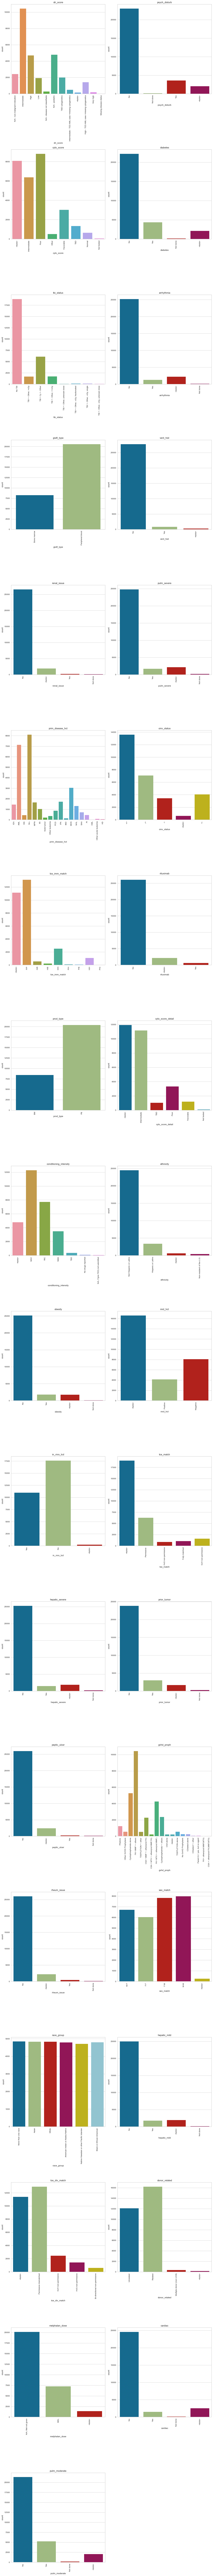

In [55]:
import math

n_cols = 2
n_plots = len(trainData_cat_copy.columns)
n_rows = math.ceil(n_plots / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10 * n_rows))
axes = axes.flatten()

for i, cols in enumerate(trainData_cat_copy.columns):
    trainData_cat_copy[cols].fillna("<NAN>", inplace=True)
    testData[cols].fillna("<NAN>", inplace=True)
    sns.countplot(data=trainData_cat_copy, x=cols, ax=axes[i])
    axes[i].set_title(cols)
    axes[i].tick_params(axis='x', rotation=90)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [52]:
print(trainData_cat_copy.isnull().sum())   
print("\n")
print(trainData_num_copy.isnull().sum())

trainData = pd.concat([trainData_cat_copy, trainData_num_copy], axis=1)

dri_score                 0
psych_disturb             0
cyto_score                0
diabetes                  0
tbi_status                0
arrhythmia                0
graft_type                0
vent_hist                 0
renal_issue               0
pulm_severe               0
prim_disease_hct          0
cmv_status                0
tce_imm_match             0
rituximab                 0
prod_type                 0
cyto_score_detail         0
conditioning_intensity    0
ethnicity                 0
obesity                   0
mrd_hct                   0
in_vivo_tcd               0
tce_match                 0
hepatic_severe            0
prior_tumor               0
peptic_ulcer              0
gvhd_proph                0
rheum_issue               0
sex_match                 0
race_group                0
hepatic_mild              0
tce_div_match             0
donor_related             0
melphalan_dose            0
cardiac                   0
pulm_moderate             0
dtype: int64


ID   

In [54]:
trainData.set_index('ID')

,dri_score,psych_disturb,cyto_score,diabetes,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,...,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs,efs_time
ID,,,,,,,,,,,,,,,,,,,,,
0.0,N/A - non-malignant indication,No,<NAN>,No,No TBI,No,Bone marrow,No,No,No,...,9.942,2.0,2.0,0.0,90.000000,8.0,2.0,10.0,0.0,42.356
1.0,Intermediate,No,Intermediate,No,"TBI +- Other, >cGy",No,Peripheral blood,No,No,No,...,43.705,2.0,2.0,3.0,90.000000,8.0,2.0,10.0,1.0,4.672
2.0,N/A - non-malignant indication,No,<NAN>,No,No TBI,No,Bone marrow,No,No,No,...,33.997,2.0,2.0,0.0,90.000000,8.0,2.0,10.0,0.0,19.793
3.0,High,No,Intermediate,No,No TBI,No,Bone marrow,No,No,No,...,43.245,2.0,2.0,0.0,90.000000,8.0,2.0,10.0,0.0,102.349
4.0,High,No,<NAN>,No,No TBI,No,Peripheral blood,No,No,No,...,29.740,2.0,2.0,1.0,90.000000,8.0,2.0,10.0,0.0,16.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795.0,Intermediate - TED AML case <missing cytogenetics,<NAN>,Favorable,No,No TBI,No,Peripheral blood,No,No,<NAN>,...,51.136,2.0,2.0,0.0,82.803885,8.0,2.0,10.0,0.0,18.633
28796.0,High,No,Poor,Yes,No TBI,No,Peripheral blood,No,No,No,...,18.075,2.0,1.0,3.0,90.000000,6.0,1.0,8.0,1.0,4.892
28797.0,TBD cytogenetics,<NAN>,Poor,<NAN>,No TBI,<NAN>,Peripheral blood,No,<NAN>,<NAN>,...,51.005,2.0,2.0,5.0,90.000000,8.0,2.0,10.0,0.0,23.157
